# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [3]:
import numpy as np

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 3.43739748001
secret_number = int_to_float(float_to_int(secret_number))
print('secret_number =', secret_number)

secret_number = 3.4373974800109863


In [4]:
number_of_best_candidates = 30
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [5]:
%%time
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s.iloc[:awr.number_of_best_candidates]

<timed exec>:1: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:207: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:207: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 14.3 s, sys: 254 ms, total: 14.5 s
Wall time: 14.6 s


3.964837    0.797285
3.998361    0.785814
3.964837    0.758056
3.998362    0.742988
3.999184    0.693136
3.999184    0.657123
3.947590    0.554603
3.947587    0.552826
3.953964    0.442872
3.938339    0.430035
3.940857    0.429248
3.972107    0.425139
3.953545    0.422484
3.937920    0.414911
3.938339    0.364544
3.947571    0.364525
3.937920    0.352644
3.940857    0.349105
3.906670    0.334208
3.947571    0.247980
2.001679    0.022020
3.437561   -0.005408
3.437515   -0.015884
2.000839   -0.033251
2.001678   -0.048648
2.003357   -0.053044
3.437561   -0.084599
2.000839   -0.097001
3.437515   -0.114206
2.003357   -0.126866
dtype: float64

## STEP-BY-STEP

### Correlation of mantissa

In [6]:
%%time

numbers = None
mantissa_correlations = {}
known_inputs = awr.build_input_values(component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):
    if numbers is not None:
        mantissa_corr = pd.Series()
        for number in numbers:
            guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=np.asarray([number]))
            corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
            mantissa_corr = pd.concat([mantissa_corr, corr.iloc[:2]])
    else:
        guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=None)
        mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

    mantissa_corr.sort_values(ascending=False, inplace=True)
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]
    mantissa_correlations[mantissa_byte_index] = mantissa_corr

<timed exec>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 12.4 s, sys: 176 ms, total: 12.6 s
Wall time: 12.6 s


01000000010110111111111001010010 3.4373974800109863 ----------
00111111110111000000000000000000 1.71875 0.26421230296357956
01000000010110111111111001010010 3.4373974800109863 ----------
00111111100000000001101110000000 1.0008392333984375 0.4555100165765221
01000000010110111111111001010010 3.4373974800109863 ----------
00111111100000000001101110000000 1.0008392333984375 0.4555100165765221


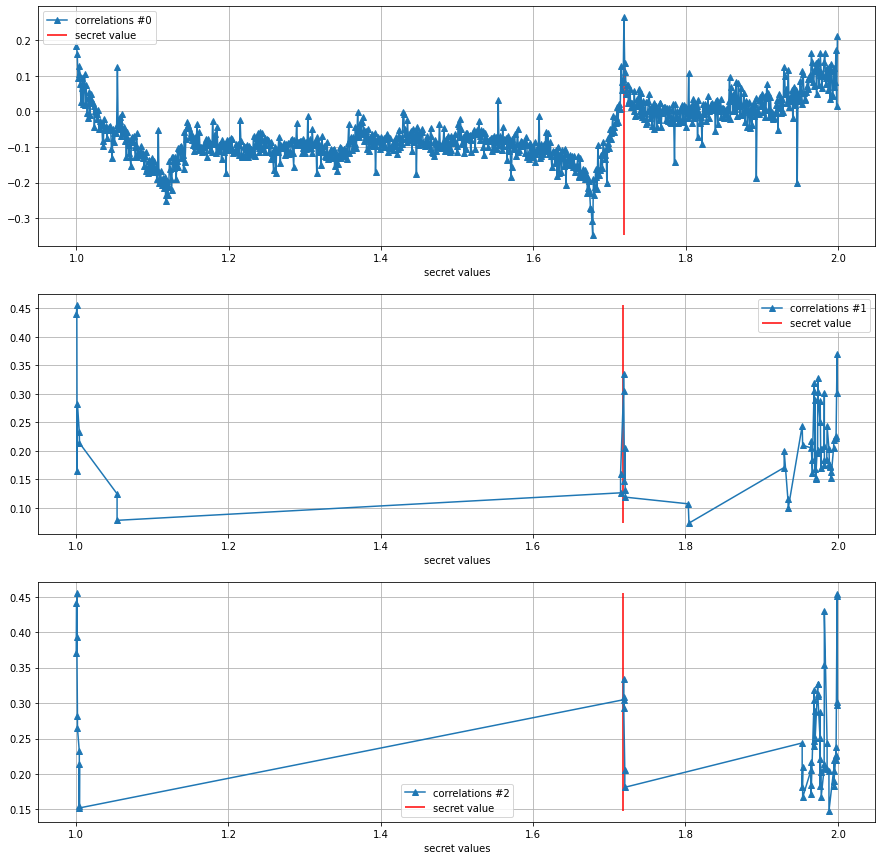

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx, kind='line', marker='^')
    x = int_to_float((float_to_int(abs(secret_number)) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')
    
    x = abs(secret_number)
    print('{:032b}'.format(float_to_int(x)), x, '-' * 10)
    x = mantissa_correlations[idx].index[0]
    print('{:032b}'.format(float_to_int(x)), x, mantissa_correlations[idx].iloc[0])

In [8]:
mantissa_correlations[2].iloc[:20]

1.000839    0.455510
1.999181    0.454422
1.999181    0.450958
1.000420    0.440579
1.982419    0.430066
1.000839    0.393404
1.000420    0.370621
1.982419    0.353356
1.718781    0.334050
1.973785    0.327224
1.973786    0.326499
1.969170    0.318121
1.973795    0.312705
1.973794    0.310011
1.718781    0.308411
1.718758    0.304761
1.968960    0.304239
1.999592    0.300903
1.999592    0.296710
1.718758    0.293278
dtype: float64

In [9]:
numbers=np.asarray(mantissa_corr.index[:awr.number_of_best_candidates])
numbers

array([1.00083923, 1.99918079, 1.99918067, 1.00041962, 1.98241866,
       1.00083935, 1.00041974, 1.98241854, 1.71878052, 1.9737854 ,
       1.97378564, 1.96916962, 1.97379518, 1.97379363, 1.71878064,
       1.71875763, 1.96895981, 1.99959183, 1.99959207, 1.71875775,
       1.97042847, 1.97698212, 1.00167847, 1.00167859, 1.97042859,
       1.97677231, 1.96916974, 1.95333481, 1.98605347, 1.96895993])

# sign

In [10]:
positive_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=numbers)
negative_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=-numbers)

In [11]:
corr = positive_corr
if positive_corr.sum() < negative_corr.sum():
    numbers = -numbers
    corr = negative_corr
numbers

array([1.00083923, 1.99918079, 1.99918067, 1.00041962, 1.98241866,
       1.00083935, 1.00041974, 1.98241854, 1.71878052, 1.9737854 ,
       1.97378564, 1.96916962, 1.97379518, 1.97379363, 1.71878064,
       1.71875763, 1.96895981, 1.99959183, 1.99959207, 1.71875775,
       1.97042847, 1.97698212, 1.00167847, 1.00167859, 1.97042859,
       1.97677231, 1.96916974, 1.95333481, 1.98605347, 1.96895993])

Text(0.5, 0, 'secret values')

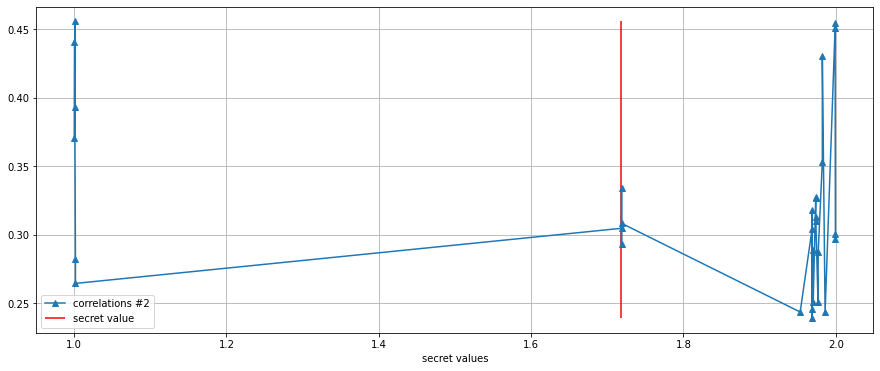

In [12]:
from matplotlib import pyplot as plt
ax = corr.sort_index().plot(label='correlations #%d' % idx, figsize=(15,6), marker='^')
x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
ax.vlines(x, corr.min(), corr.max(), color='red', label='secret value')
ax.legend()
ax.grid(True)
ax.set_xlabel('secret values')

### Correlation exponent

In [13]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

mantisa_exp_corr = pd.Series()
for number in numbers:
    guess_numbers = AdvancedWeightRecovery.build_guess_values(component='exponent', numbers=np.asarray([number]))
    guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
    corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False).iloc[:awr.number_of_best_candidates]
    mantisa_exp_corr = pd.concat([mantisa_exp_corr, corr.iloc[:2]])
# get the best values
mantisa_exp_corr.sort_values(ascending=False, inplace=True)
numbers = np.asarray(mantisa_exp_corr.index[:awr.number_of_best_candidates])

<timed exec>:2: RuntimeWarning: overflow encountered in multiply
<timed exec>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:7: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:7: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.69 s, sys: 23.8 ms, total: 1.72 s
Wall time: 1.72 s


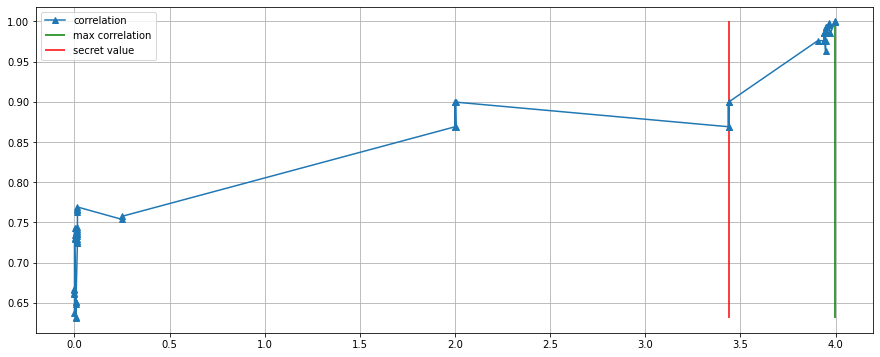

In [14]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [15]:
mantisa_exp_corr.iloc[:awr.number_of_best_candidates]

3.999184    1.000000
3.998361    0.999378
3.999184    0.999282
3.998362    0.999282
3.964837    0.997682
3.964837    0.995135
3.947590    0.992540
3.947587    0.992540
3.953545    0.985753
3.938339    0.985753
3.940857    0.985753
3.937920    0.985753
3.953964    0.985753
3.972107    0.985753
3.937920    0.976111
3.906670    0.976111
3.938339    0.976111
3.940857    0.976111
3.947571    0.976111
3.947571    0.963141
3.437561    0.899633
2.003357    0.899633
3.437515    0.899633
2.001679    0.899633
2.000839    0.899633
2.001678    0.869008
2.003357    0.869008
2.000839    0.869008
3.437561    0.869008
3.437515    0.869008
dtype: float64

### Last sorting

<ipython-input-16-43f50eaea3ae>:3: RuntimeWarning: overflow encountered in multiply
  secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


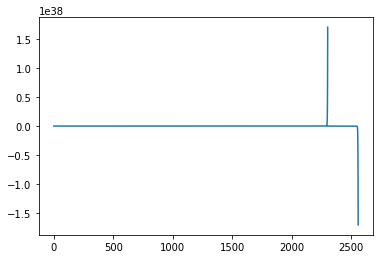

In [16]:
known_inputs = np.concatenate((awr.build_input_values(component='mantissa'), awr.build_input_values(component='exponent')))
#known_inputs = np.random.uniform(-1, 1, 1000)
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
full_corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, numbers).sort_values(ascending=False)
pd.Series(known_inputs).plot()

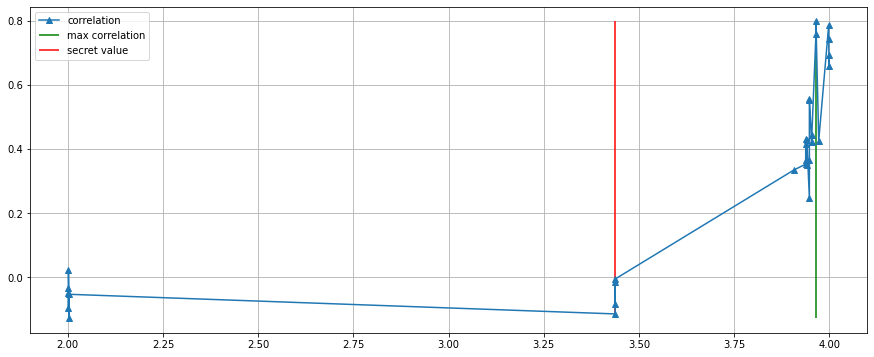

In [17]:
ax = full_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(full_corr.idxmax(), full_corr.min(), full_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_corr.min(), full_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [18]:
full_corr.iloc[:awr.number_of_best_candidates]

3.964837    0.797285
3.998361    0.785814
3.964837    0.758056
3.998362    0.742988
3.999184    0.693136
3.999184    0.657123
3.947590    0.554603
3.947587    0.552826
3.953964    0.442872
3.938339    0.430035
3.940857    0.429248
3.972107    0.425139
3.953545    0.422484
3.937920    0.414911
3.938339    0.364544
3.947571    0.364525
3.937920    0.352644
3.940857    0.349105
3.906670    0.334208
3.947571    0.247980
2.001679    0.022020
3.437561   -0.005408
3.437515   -0.015884
2.000839   -0.033251
2.001678   -0.048648
2.003357   -0.053044
3.437561   -0.084599
2.000839   -0.097001
3.437515   -0.114206
2.003357   -0.126866
dtype: float64

### Result

In [19]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 0
x = full_corr.index[idx]
print('{:032b}'.format(float_to_int(x)), x, full_corr.iloc[idx])

01000000010110111111111001010010 3.4373974800109863
01000000011111011011111111100101 3.9648373126983643 0.7972845975502012


In [20]:
print('secret_number:', secret_number)
print('the best guessed value:', full_corr.index[0], 'Correlation:', full_corr.iloc[0])

secret_number: 3.4373974800109863
the best guessed value: 3.9648373126983643 Correlation: 0.7972845975502012
